

# Self-Aware Transformer Agent for Trading

## Motivation

Traditional RL trading agents rely heavily on market signals. But the market is noisy, volatile, and unpredictable — especially in short windows. Instead of chasing external patterns, we **shift the focus inward**:

> Teach the agent to interpret itself, its context, and act based on internal understanding and consistent behavior.

This system mimics how **career traders** operate: not by predicting price ticks, but by reacting intelligently to their strategy performance, risk levels, and regime shifts.

---

## Agent Design Philosophy

| Principle                | Implementation                                                         |
| ------------------------ | ---------------------------------------------------------------------- |
| Internal State Awareness | Agent tracks position, time held, drawdown, unrealized PnL             |
| Compact, Dense Features  | Handcrafted candlestick + PCA-compressed signals                       |
| Regime-Driven Training   | Train using rolling market windows with real history                   |
| Transformer Context Use  | Use long context (2 months) to act intelligently in the next (1 month) |
| Reward Discipline        | Combine PnL, drawdown penalty, and Sharpe-style consistency bonus      |

---

## Feature Engineering: `FeatureCompressor`

| Feature Group        | Description                                          |
| -------------------- | ---------------------------------------------------- |
| Candlestick Shape    | `body`, `upper_shadow`, `lower_shadow`, `body_ratio` |
| Relative Behavior    | `z_close`, `rel_volume`, `price_vs_range`            |
| Signal Strength      | `rolling_sharpe`, `entropy`                          |
| Historical Embedding | `pca_1`, `pca_2` from rolling PCA of close/volume    |

All features are window-smoothed to reduce noise and expose true structure.

---

## Custom Environment: `SelfAwareTradingEnv`

* Builds the agent's **state** with both market and internal agent features
* Internal metrics: position, time held, cumulative reward, drawdown, unrealized PnL, pct episode completed
* **Reward Function**:

  ```python
  shaped_reward = (
      0.5 * raw_pnl
      + 0.3 * sharpe_bonus
      - 0.2 * drawdown_penalty
  )
  ```

---

## Transformer Architecture

* Input: full feature state (market + internal), padded or clipped to 60 steps
* Positional encoding: learnable
* Backbone: TransformerEncoder (2 layers, 4 heads)
* Outputs a context vector per timestep → passed to actor & critic
* Integrated with `RecurrentPPO` for temporal memory

---

## Windowed Training Design

Each training episode is built from a **single ticker**:

| Step | Description                                                                     |
| ---- | ------------------------------------------------------------------------------- |
| 1    | Select a ticker and sort its data by date                                       |
| 2    | Slice 60 days as `context` and next 30 as `target`                              |
| 3    | Use only `target` for training, but allow agent to leverage Transformer context |
| 4    | Repeat across all valid rolling windows and tickers                             |

This creates hundreds of **coherent, regime-aware episodes** for training and evaluation.

---

## Full Pipeline Summary

```text
load_base_dataframe()
↓
MarketWindowBuilder → [context_df, target_df] for each ticker
↓
FeatureCompressor → Compress raw OHLCV into ~10 descriptive features
↓
SelfAwareTradingEnv → Builds internal + market state, shaped rewards
↓
RecurrentPPO (TransformerPolicy) → Trains over target month
↓
EpisodeLoggerCallback → Tracks Sharpe, Win Rate, Drawdown, # Trades
↓
EvaluationRunner → Loads each agent window and scores deterministically
```

---

## Evaluation & Benchmarking

Each agent is evaluated on the same `target_df` it was trained on, using **deterministic inference**. Logged metrics include:

| Metric         | Description                                      |
| -------------- | ------------------------------------------------ |
| `total_reward` | Sum of all rewards in episode                    |
| `avg_reward`   | Mean reward per step                             |
| `sharpe_bonus` | Volatility-adjusted consistency score            |
| `drawdown`     | Max drawdown during episode                      |
| `win_rate`     | % of profitable actions (to be optionally added) |

Results are saved in `evaluation_results.csv` and can be compared across:

* Tickers
* Time periods
* Volatility regimes

---

## Benchmark Plan

| Baseline             | Description                                                |
| -------------------- | ---------------------------------------------------------- |
| Random Policy        | Random action sampling, same environment                   |
| Hold-only Agent      | Buy once and hold through episode                          |
| Classical PPO w/ MLP | Same pipeline, no memory or context                        |
| Market Benchmark     | Cumulative return of passive exposure during target period |

We will compute **performance deltas** against these baselines and track:

* Sharpe outperformance
* Drawdown reduction
* Adaptation to volatile periods

---

## What Makes This Unique?

* Agent **doesn’t predict**, it *reacts adaptively*
* Context is used **intelligently**, not just stacked
* Agent performance is **relative to itself**, not absolute return
* Internal state + compressed signals = **compact but expressive space**




In [1]:
# SETUP ===================================
import jupyter
import warnings

from src.utils.system import boot, Notify

boot()
warnings.filterwarnings("ignore")



# PACKAGES ================================
import os
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import  RobustScaler
from IPython.display import display

# FRAMEWORK STUFF =========================
from src.defaults import TOP2_STOCK_BY_SECTOR, FEATURE_COLS,EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
from src.experiments.experiment_tracker import ExperimentTracker

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy



In [2]:
""""
You want short-term sensitivity, reduce to 5
You want longer context, increase to 20+
But since the Transformer also has its own memory (seq_len=60), this window should capture local structure, while the Transformer will detect global structure across those.
Would you like to try a few window values and compare feature statistics or training metrics?
"""
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

class FeatureCompressor:
    def __init__(self, window=10):
        self.window = window
        self.pca = PCA(n_components=2)

    def transform(self, df):
        df = df.copy()

        # === CANDLE FEATURES ===
        df['body'] = df['close'] - df['open']
        df['upper_shadow'] = df['high'] - df[['open', 'close']].max(axis=1)
        df['lower_shadow'] = df[['open', 'close']].min(axis=1) - df['low']
        df['range'] = df['high'] - df['low']
        df['body_ratio'] = df['body'] / (df['range'] + 1e-8)

        # === RELATIVE CONTEXT FEATURES ===
        df['z_close'] = (df['close'] - df['close'].rolling(self.window).mean()) / (df['close'].rolling(self.window).std() + 1e-8)
        df['rel_volume'] = df['volume'] / (df['volume'].rolling(self.window).mean() + 1e-8)
        df['price_vs_range'] = (df['close'] - df['low'].rolling(self.window).min()) / (
            df['high'].rolling(self.window).max() - df['low'].rolling(self.window).min() + 1e-8)

        # === SIGNAL QUALITY (EWM) ===
        df['return'] = df['close'].pct_change()
        df['ewm_return_mean'] = df['return'].ewm(span=self.window).mean()
        df['ewm_return_std'] = df['return'].ewm(span=self.window).std()
        df['rolling_sharpe'] = df['ewm_return_mean'] / (df['ewm_return_std'] + 1e-8)
        df['entropy'] = df['return'].rolling(self.window).apply(self.shannon_entropy, raw=True)

        # === PCA EMBEDDING ===
        pca_inputs = []
        raw = df[['close', 'volume']].fillna(0).values
        for i in range(self.window, len(raw)):
            window = raw[i - self.window:i].flatten()
            pca_inputs.append(window)

        if len(pca_inputs) > 0:
            compressed = self.pca.fit_transform(np.array(pca_inputs))
            df.loc[df.index[-len(compressed):], 'pca_1'] = compressed[:, 0]
            df.loc[df.index[-len(compressed):], 'pca_2'] = compressed[:, 1]
        else:
            df['pca_1'] = 0
            df['pca_2'] = 0

        # === DATE-TIME FEATURES ===
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'])
            df['day_of_week'] = df['date'].dt.dayofweek
            df['day_of_month'] = df['date'].dt.day
            df['month'] = df['date'].dt.month
        else:
            df['day_of_week'] = 0
            df['day_of_month'] = 0
            df['month'] = 0

        # === FINAL FEATURE SET ===
        features = [
            'body', 'upper_shadow', 'lower_shadow', 'body_ratio',
            'z_close', 'rel_volume', 'price_vs_range',
            'rolling_sharpe', 'entropy',
            'pca_1', 'pca_2',
            'day_of_week', 'day_of_month', 'month'
        ]

        return df[features].dropna().reset_index(drop=True)

    def shannon_entropy(self, x):
        hist, bins = np.histogram(x, bins=5, density=True)
        hist = hist[hist > 0]
        return -np.sum(hist * np.log(hist + 1e-8))


In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque

class SelfAwareTradingEnv(gym.Env):
    def __init__(self, market_array, sequence_length=42, episode_length=None):
        super().__init__()
        self.market_data = market_array
        self.sequence_length = sequence_length
        self.episode_length = episode_length or len(market_array)

        self.feature_dim = self.market_data.shape[1]
        self.internal_dim = 6  # position, time_in_pos, unrealized_pnl, total_reward, drawdown, step_pct
        self.observation_dim = self.feature_dim + self.internal_dim

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.sequence_length, self.observation_dim),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # Buy, Sell, Hold

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = 0
        self.total_reward = 0
        self.current_position = 0
        self.entry_price = None
        self.time_in_position = 0
        self.max_reward = 0
        self.observation_buffer = []

        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        if self.current_step >= len(self.market_data):
            # Prevent out-of-bounds
            pad = np.zeros(self.feature_dim)
            market_features = pad
        else:
            market_features = self.market_data[self.current_step]

        internal_features = np.array([
            self.current_position,
            self.time_in_position,
            self.calc_unrealized_pnl(),
            self.total_reward,
            self.calc_drawdown(),
            self.current_step / self.episode_length
        ])

        full_obs = np.concatenate([market_features, internal_features])
        self.observation_buffer.append(full_obs)

        if len(self.observation_buffer) > self.sequence_length:
            self.observation_buffer.pop(0)

        while len(self.observation_buffer) < self.sequence_length:
            self.observation_buffer.insert(0, np.zeros_like(full_obs))

        return np.stack(self.observation_buffer, axis=0)

    def step(self, action):
        if self.current_step >= self.episode_length:
            # Episode over
            return self._get_obs(), 0.0, True, False, {}

        price = self.market_data[self.current_step, 0]  # Assuming first feature is close

        raw_reward = 0.0
        if action == 0:  # SELL
            if self.current_position == 1:
                raw_reward = price - self.entry_price
                self.total_reward += raw_reward
                self.current_position = 0
                self.entry_price = None
                self.time_in_position = 0

        elif action == 1:  # BUY
            if self.current_position == 0:
                self.entry_price = price
                self.current_position = 1
                self.time_in_position = 1
            else:
                self.time_in_position += 1

        elif action == 2:  # HOLD
            if self.current_position == 1:
                self.time_in_position += 1

        # Reward shaping
        shaped_reward = (
            0.5 * raw_reward +
            0.3 * self.sharpe_bonus() -
            0.2 * self.calc_drawdown()
        )

        self.total_reward += shaped_reward
        self.max_reward = max(self.max_reward, self.total_reward)
        self.current_step += 1

        done = self.current_step >= self.episode_length
        return self._get_obs(), shaped_reward, done, False, {}

    def calc_unrealized_pnl(self):
        if self.current_position == 0 or self.entry_price is None:
            return 0.0
        price = self.market_data[min(self.current_step, len(self.market_data) - 1), 0]
        return price - self.entry_price

    def calc_drawdown(self):
        return max(0.0, self.max_reward - self.total_reward)

    def sharpe_bonus(self):
        # Placeholder: simple proxy
        return np.sign(self.total_reward) * np.sqrt(abs(self.total_reward)) / 10


In [4]:
from stable_baselines3.common.callbacks import BaseCallback
class EpisodeLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_data = []

    def _on_step(self):
        info = self.locals.get('infos', [{}])[0]
        if 'episode' in info:
            self.episode_data.append(info['episode'])
        return True

    def _on_training_end(self):
        df = pd.DataFrame(self.episode_data)
        df.to_csv('agent_journal.csv', index=False)
        print("✅ Saved trading journal to agent_journal.csv")

In [5]:

import pandas as pd

class MarketWindowBuilder:
    def __init__(self, df: pd.DataFrame, context_days=40, target_days=20, ticker_col='symbol', date_col='date'):
        self.df = df.copy()
        self.context_days = context_days
        self.target_days = target_days
        self.ticker_col = ticker_col
        self.date_col = date_col

    def generate_windows(self):
        windows = []
        grouped = self.df.groupby(self.ticker_col)

        for symbol, group in grouped:
            group = group.sort_values(self.date_col).reset_index(drop=True)
            total_days = self.context_days + self.target_days

            for start_idx in range(0, len(group) - total_days):
                context = group.iloc[start_idx : start_idx + self.context_days].copy()
                target = group.iloc[start_idx + self.context_days : start_idx + total_days].copy()

                windows.append({
                    'symbol': symbol,
                    'context': context.reset_index(drop=True),
                    'target': target.reset_index(drop=True)
                })

        return windows


In [6]:
class WindowedTrainingLoader:
    def __init__(self, raw_df, context_days=40, target_days=20, window_step=20):
        self.raw_df = raw_df
        self.context_days = context_days
        self.target_days = target_days
        self.window_step = window_step
        self.compressor = FeatureCompressor(window=10)

    def get_training_environments(self):
        envs = []
        window_size = self.compressor.window

        for ticker, group in self.raw_df.groupby("symbol"):
            group = group.sort_values("date").reset_index(drop=True)
            total_days = len(group)

            # Total days needed: context + target + compression lag
            required_input = self.context_days + self.target_days + window_size - 1
            start_indices = range(0, total_days - required_input, self.window_step)

            for start in start_indices:
                context = group.iloc[start : start + self.context_days]
                target = group.iloc[
                    start + self.context_days : start + self.context_days + self.target_days + window_size - 1
                ]

                if len(context) < self.context_days or len(target) < self.target_days + window_size - 1:
                    continue

                # Combine context + extended target for compression
                full = pd.concat([context, target])
                compressed = self.compressor.transform(full)

                # Get only the compressed target window
                target_compressed = compressed.iloc[-self.target_days:].to_numpy()

                env = SelfAwareTradingEnv(
                    market_array=target_compressed,
                    sequence_length=10,
                    episode_length=len(target_compressed)
                )

                envs.append({
                    "ticker": ticker,
                    "context": context,
                    "target_env": env
                })

        return envs


| Component         | Purpose                                                   | Use Cases / Benefits                                    |
| ----------------- | --------------------------------------------------------- | ------------------------------------------------------- |
| `advantage_head`  | Predicts how much **edge** the agent expects from a state | Detect market opportunities or stale/noisy environments |
| `confidence_head` | Predicts how **confident** the agent is in its decision   | Suppress overtrading in noisy periods                   |
| Logging those     | Helps you **analyze** what the agent sees as risky, easy  | Visualize uncertainty over time or by ticker            |

### Dev note: 
Decidi alimentar observation state com confidence_score para o cabrão se autoregular


In [7]:
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, seq_len=60, embed_dim=64, n_heads=4, n_layers=2):
        super().__init__(observation_space, features_dim=embed_dim + 1)  # +1 for confidence

        self.seq_len = seq_len
        self.embed_dim = embed_dim

        self.input_dim = observation_space.shape[-1]
        self.embedding = nn.Linear(self.input_dim, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.output_layer = nn.Linear(embed_dim, embed_dim)
        self.confidence_head = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  # Confidence between 0 and 1
        )

    def forward(self, obs):
        B, T, F = obs.shape  # Batch, Time, Features
        x = self.embedding(obs)
        x = x + self.pos_embedding[:, :T, :]
        x = self.encoder(x)
        x_last = x[:, -1]
        confidence = self.confidence_head(x_last)
        return torch.cat([x_last, confidence], dim=-1)


from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

class SelfAwareTransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            **kwargs,
            features_extractor_class=TransformerFeatureExtractor,
            features_extractor_kwargs=dict(seq_len=60, embed_dim=64, n_heads=4, n_layers=2)
        )

    def extract_features(self, obs: torch.Tensor):
        return self.features_extractor(obs)


In [8]:
import os
import pandas as pd
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO

class TrainingRunner:
    def __init__(self, raw_ohlcv_df, model_save_path="self_aware_agent", total_timesteps=10_000):
        self.raw_df = raw_ohlcv_df
        self.model_save_path = model_save_path
        self.total_timesteps = total_timesteps

    def run(self):
        print('Run start')
        loader = WindowedTrainingLoader(self.raw_df)
        print('Loader initialized')
        episodes = loader.get_training_environments()
        print('Episodes loaded ',len(episodes))

        # Resume logic
        journal_path = "training_journal.csv"
        if os.path.exists(journal_path):
            completed_windows = set(pd.read_csv(journal_path)['window'].unique())
            all_metrics = [pd.read_csv(journal_path)]
        else:
            completed_windows = set()
            all_metrics = []

        for i, episode in enumerate(tqdm(episodes, desc="Training windows")):
            window_id = i + 1
            model_path = os.path.join(self.model_save_path, f"agent_window_{window_id}.zip")

            if window_id in completed_windows or os.path.exists(model_path):
                print(f"⏩ Skipping window {window_id}, already completed.")
                continue

            context_df = episode['context']
            env = DummyVecEnv([lambda: Monitor(episode['target_env'])])

            model = RecurrentPPO(
                policy=SelfAwareTransformerPolicy,
                env=env,
                verbose=0,
            )

            print(f"\nTraining window {window_id}/{len(episodes)}")

            callback = EpisodeLoggerCallback()
            model.learn(total_timesteps=self.total_timesteps, callback=callback)

            os.makedirs(self.model_save_path, exist_ok=True)
            model.save(model_path)
            print('Saved model @ '+model_path)

            # Append and immediately persist metrics for crash resilience
            episode_df = pd.DataFrame(callback.episode_data)
            episode_df['window'] = window_id
            all_metrics.append(episode_df)

            pd.concat(all_metrics, ignore_index=True).to_csv(journal_path, index=False)

        print("\n✅ Training complete. Journal saved to 'training_journal.csv'")

In [9]:
notification = Notify('Self aware trading agent')
notification.success('Lets go')

In [10]:
raw_df = load_base_dataframe()
raw_df = raw_df.sort_values("date").reset_index(drop=True)
raw_df = raw_df[(raw_df['date']>="2024-01-01") & (raw_df['date']<'2025-06-01')]
raw_df = raw_df[raw_df['symbol'].isin(['AAPL','GOOGL'])]

# TRAIN THIS DUDE ====================================
runner = TrainingRunner(
    raw_ohlcv_df=raw_df,
    model_save_path="self_aware_transformer",
    total_timesteps=10_000 
)
notification.info('Train started')
runner.run()
notification.info('Train complete')

Run start
Loader initialized
Episodes loaded  30


Training windows:   0%|          | 0/30 [00:00<?, ?it/s]

⏩ Skipping window 1, already completed.
⏩ Skipping window 2, already completed.

Training window 3/30


Training windows:  10%|█         | 3/30 [03:52<34:55, 77.62s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_3.zip

Training window 4/30


Training windows:  13%|█▎        | 4/30 [08:37<1:02:31, 144.29s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_4.zip

Training window 5/30


Training windows:  17%|█▋        | 5/30 [12:55<1:15:06, 180.24s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_5.zip

Training window 6/30


Training windows:  20%|██        | 6/30 [17:00<1:20:10, 200.43s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_6.zip

Training window 7/30


Training windows:  23%|██▎       | 7/30 [21:10<1:22:36, 215.49s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_7.zip

Training window 8/30


Training windows:  27%|██▋       | 8/30 [25:18<1:22:39, 225.41s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_8.zip

Training window 9/30


Training windows:  30%|███       | 9/30 [29:29<1:21:37, 233.20s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_9.zip

Training window 10/30


Training windows:  33%|███▎      | 10/30 [33:44<1:19:56, 239.81s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_10.zip

Training window 11/30


Training windows:  37%|███▋      | 11/30 [37:55<1:17:03, 243.34s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_11.zip

Training window 12/30


Training windows:  40%|████      | 12/30 [42:06<1:13:40, 245.60s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_12.zip

Training window 13/30


Training windows:  43%|████▎     | 13/30 [46:21<1:10:20, 248.27s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_13.zip

Training window 14/30


Training windows:  47%|████▋     | 14/30 [50:34<1:06:35, 249.74s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_14.zip

Training window 15/30


Training windows:  50%|█████     | 15/30 [54:44<1:02:29, 249.98s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_15.zip

Training window 16/30


Training windows:  53%|█████▎    | 16/30 [58:57<58:33, 250.93s/it]  

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_16.zip

Training window 17/30


Training windows:  57%|█████▋    | 17/30 [1:03:09<54:24, 251.13s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_17.zip

Training window 18/30


Training windows:  60%|██████    | 18/30 [1:07:23<50:25, 252.09s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_18.zip

Training window 19/30


Training windows:  63%|██████▎   | 19/30 [1:11:38<46:20, 252.78s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_19.zip

Training window 20/30


Training windows:  67%|██████▋   | 20/30 [1:15:53<42:14, 253.46s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_20.zip

Training window 21/30


Training windows:  70%|███████   | 21/30 [1:20:04<37:56, 252.95s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_21.zip

Training window 22/30


Training windows:  73%|███████▎  | 22/30 [1:24:19<33:46, 253.29s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_22.zip

Training window 23/30


Training windows:  77%|███████▋  | 23/30 [1:28:33<29:35, 253.70s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_23.zip

Training window 24/30


Training windows:  80%|████████  | 24/30 [1:32:43<25:15, 252.64s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_24.zip

Training window 25/30


Training windows:  83%|████████▎ | 25/30 [1:36:58<21:06, 253.21s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_25.zip

Training window 26/30


Training windows:  87%|████████▋ | 26/30 [1:41:09<16:50, 252.61s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_26.zip

Training window 27/30


Training windows:  90%|█████████ | 27/30 [1:45:21<12:37, 252.42s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_27.zip

Training window 28/30


Training windows:  93%|█████████▎| 28/30 [1:49:37<08:27, 253.61s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_28.zip

Training window 29/30


Training windows:  97%|█████████▋| 29/30 [1:53:51<04:13, 253.68s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_29.zip

Training window 30/30


Training windows: 100%|██████████| 30/30 [1:58:03<00:00, 236.12s/it]

✅ Saved trading journal to agent_journal.csv
Saved model @ self_aware_transformer\agent_window_30.zip

✅ Training complete. Journal saved to 'training_journal.csv'


In [11]:
class MarketVersusWalletHistoryTracker:
    def __init__(self, initial_wallet=1.0):
        self.wallet_value = initial_wallet
        self.prev_wallet_value = initial_wallet
        self.wallet_locked = False
        self.buy_price = None
        self.market_entry_price = None
        self.last_price = None
        self.has_opened_position = False  # NEW: ensure proper update after first buy

        self.wallet_history = []
        self.market_history = []
        self.price_history = []
        self.action_history = []

    def reset(self, initial_price):
        self.__init__(initial_wallet=1.0)
        self.market_entry_price = initial_price
        self.last_price = initial_price
        self.wallet_history.append(self.wallet_value)
        self.market_history.append(1.0)
        self.price_history.append(initial_price)
        self.action_history.append(0)

    def step(self, action, current_price):
        self.price_history.append(current_price)
        agent_action = 0

        # === 1. Update market benchmark ===
        market_perf = current_price / self.market_entry_price
        self.market_history.append(market_perf)

        # === 2. Update wallet value ===
        if self.wallet_locked and self.has_opened_position:
            self.wallet_value *= current_price / self.last_price

        self.wallet_history.append(self.wallet_value)
        self.prev_wallet_value = self.wallet_value
        self.last_price = current_price  # must be set after wallet update!

        # === 3. Process Action ===
        if action == 1 and not self.wallet_locked:
            self.buy_price = current_price
            self.wallet_locked = True
            self.has_opened_position = True
            agent_action = 1

        elif action == 2 and self.wallet_locked:
            self.wallet_locked = False
            self.buy_price = None
            self.has_opened_position = False
            agent_action = 2

        self.action_history.append(agent_action)

    def export(self):
        return {
            "wallet_history": self.wallet_history,
            "market_history": self.market_history,
            "market_price_history": self.price_history,
            "performed_action_history": self.action_history
        }


In [12]:
import json

# === SAFE CONVERSION TO JSON-SERIALIZABLE STRUCTURE ===
import numpy as np

def to_serializable(obj):
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_serializable(x) for x in obj]
    elif isinstance(obj, np.generic):  # includes np.float32, np.int32, etc.
        return obj.item()
    else:
        return obj
    
class EvaluationRunner:
    def __init__(self, raw_df, model_path="self_aware_transformer"):
        self.raw_df = raw_df
        self.model_path = model_path
        self.compressor = FeatureCompressor(window=10)

    def run(self):
        print("Starting evaluation...")
        loader = WindowedTrainingLoader(self.raw_df)
        windows = loader.get_training_environments()

        all_results = []

        for i, episode in enumerate(tqdm(windows, desc="Evaluating windows")):
            window_id = i + 1
            model_file = os.path.join(self.model_path, f"agent_window_{window_id}.zip")
            if not os.path.exists(model_file):
                print(f"⚠️ Model for window {window_id} not found, skipping.")
                continue

            env = DummyVecEnv([lambda: Monitor(episode['target_env'])])
            model = RecurrentPPO.load(model_file, env=env, policy=SelfAwareTransformerPolicy)

            obs = env.reset()
            lstm_states = None
            done = False
            rewards = []
            actions = []
            confidences = []

            tracker = MarketVersusWalletHistoryTracker()
            tracker.reset(initial_price=episode['target_env'].market_data[0, 0])

            while not done:
                action, lstm_states = model.predict(obs, state=lstm_states, deterministic=True)
                obs, reward, done, info = env.step(action)

                rewards.append(reward[0])
                actions.append(action[0])

                current_price = episode['target_env'].market_data[
                    min(episode['target_env'].current_step, len(episode['target_env'].market_data) - 1), 0
                ]
                tracker.step(action[0], current_price)

                confidence = obs[0, -1, -1].item()
                confidences.append(confidence)

            cumulative_reward = np.sum(rewards)
            mean_confidence = np.mean(confidences)
            num_trades = np.sum(np.array(actions) != 2)

            export = tracker.export()

            all_results.append({
                "window": window_id,
                "ticker": episode["ticker"],
                "cumulative_reward": cumulative_reward,
                "mean_confidence": mean_confidence,
                "num_trades": num_trades,
                "buy_count": np.sum(np.array(export['performed_action_history']) == 1),
                "sell_count": np.sum(np.array(export['performed_action_history']) == 2),
                "wallet_history": export['wallet_history'],
                "market_history": export['market_history'],
                "price_history": export['market_price_history'],
                "action_history": export['performed_action_history']
            })
        
        df = pd.DataFrame(all_results)
        df.to_csv("evaluation_report.csv", index=False)

        
        serializable_results = [to_serializable(res) for res in all_results]

        with open("evaluation_history.json", "w") as f:
            json.dump(serializable_results, f, indent=2)
            
        print("✅ Evaluation report saved to evaluation_report.csv")


In [13]:
#raw_df = load_base_dataframe()
#raw_df = raw_df.sort_values("date").reset_index(drop=True)
#raw_df = raw_df[(raw_df['date']>="2024-12-01") & (raw_df['date']<'2025-06-01')]
notification.info('Test started')
eval_runner = EvaluationRunner(raw_df)
eval_runner.run()
notification.info('Test complete')

Starting evaluation...


Evaluating windows: 100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


✅ Evaluation report saved to evaluation_report.csv


In [14]:
import json

with open("evaluation_history.json", 'r') as openfile:

    json_object = json.load(openfile)
    
print(json_object)

[{'window': 1, 'ticker': 'AAPL', 'cumulative_reward': 0.0, 'mean_confidence': 0.47500000055879354, 'num_trades': 0, 'buy_count': 0, 'sell_count': 0, 'wallet_history': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'market_history': [1.0, -0.05487804878048939, -0.8841463414634171, 1.1280487804877912, -1.0609756097560936, -1.798780487804855, 3.4634146341463143, -0.3170731707317107, -0.1737804878048744, 0.17682926829267648, -1.7682926829268169, 0.16463414634146817, 0.7073170731707232, 0.14634146341463838, -0.5243902439024426, 0.8963414634146254, 0.006097560975604156, 0.3536585365853703, -0.5914634146341403, 0.6219512195121958, 1.0], 'price_history': [-1.6400000000000148, 0.09000000000000341, 1.450000000000017, -1.8499999999999943, 1.740000000000009, 2.9499999999999886, -5.680000000000007, 0.5200000000000102, 0.2849999999999966, -0.28999999999999204, 2.9000000000000057, -0.27000000000001023, -1.1599999999999966, -0.240000000000009

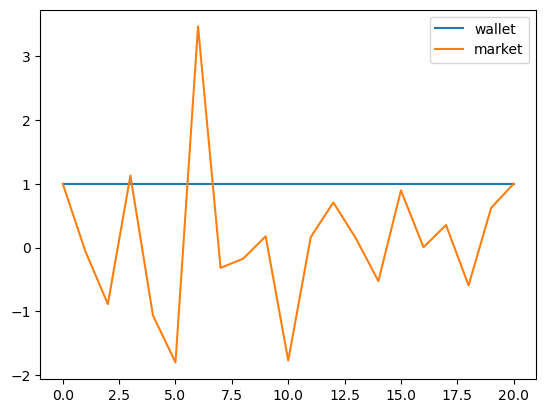

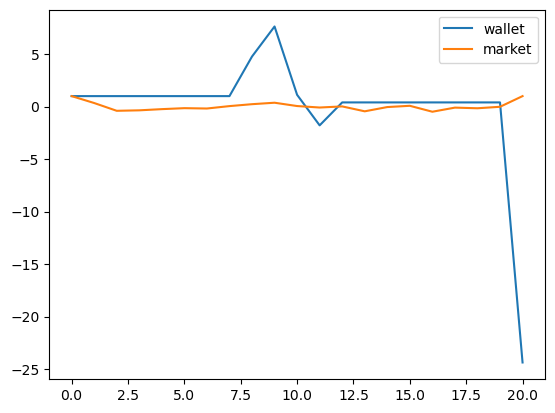

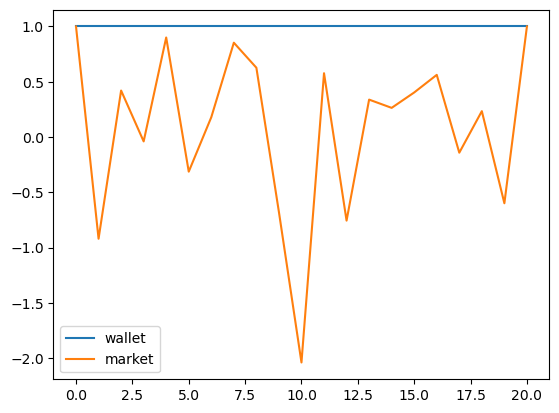

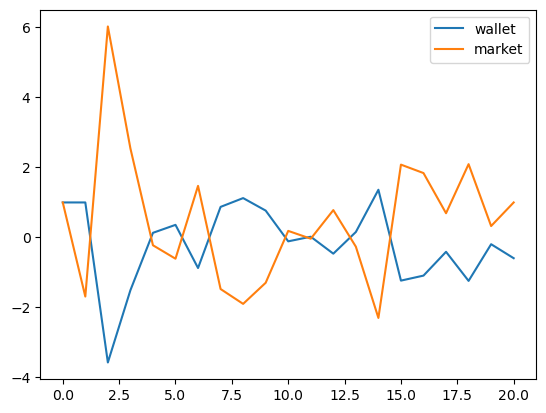

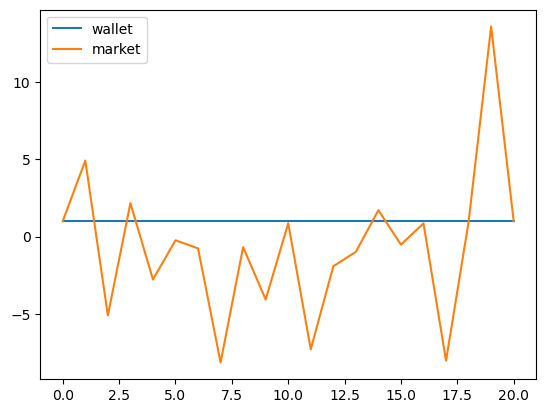

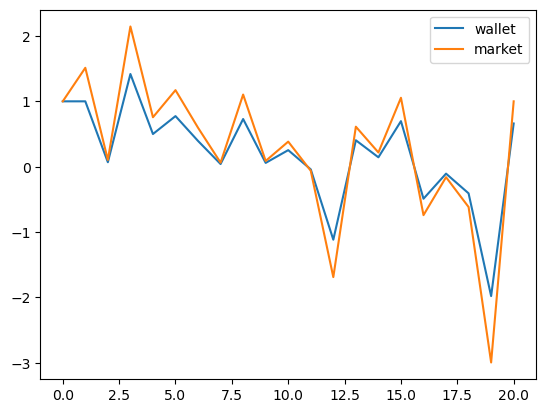

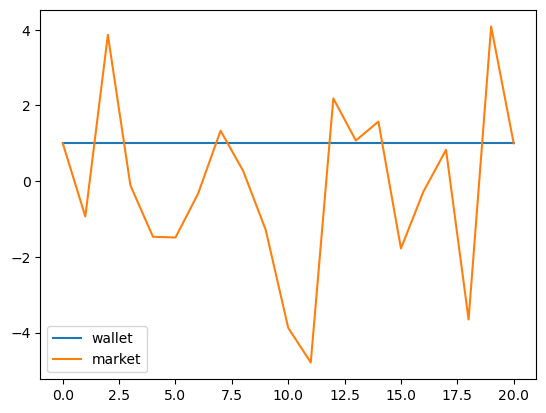

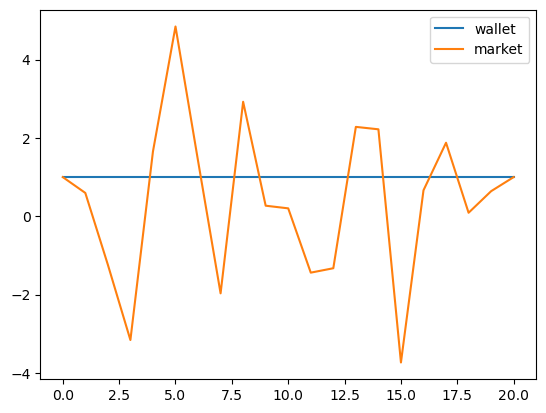

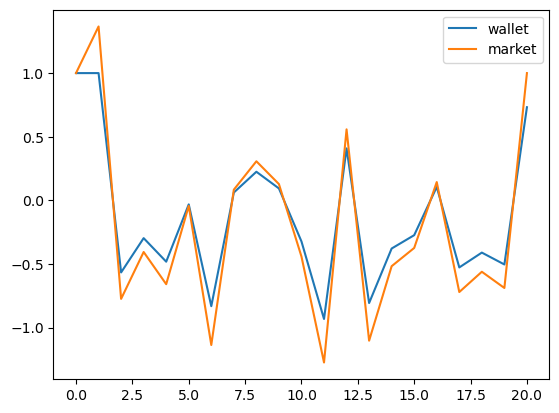

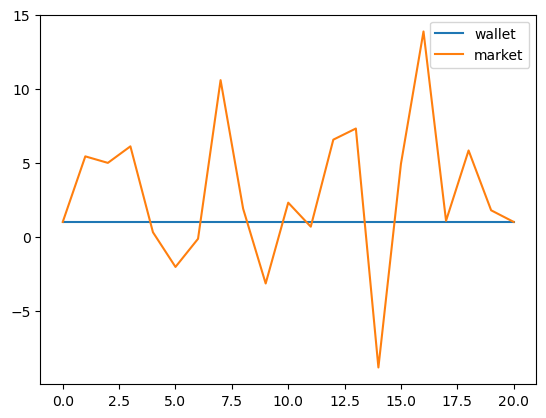

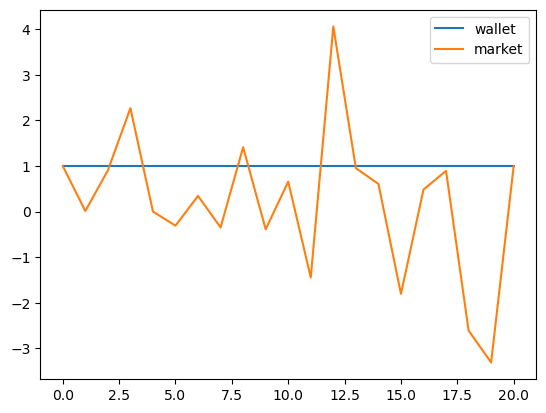

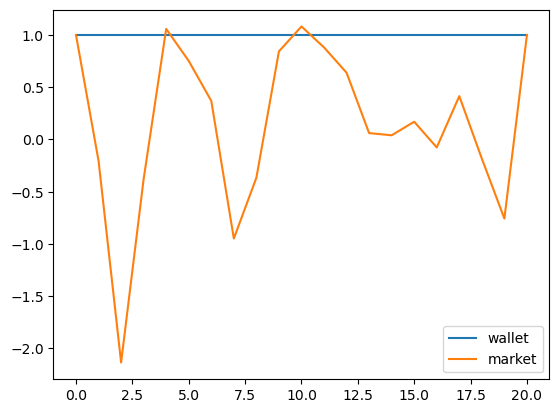

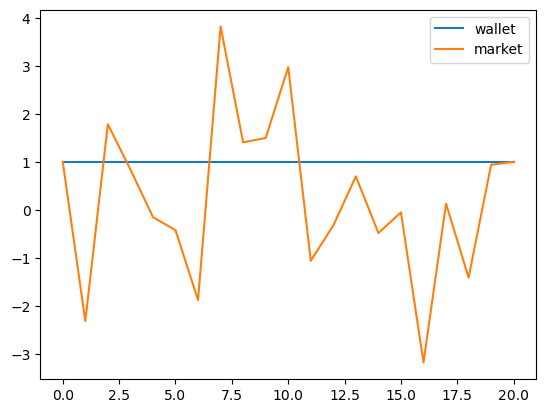

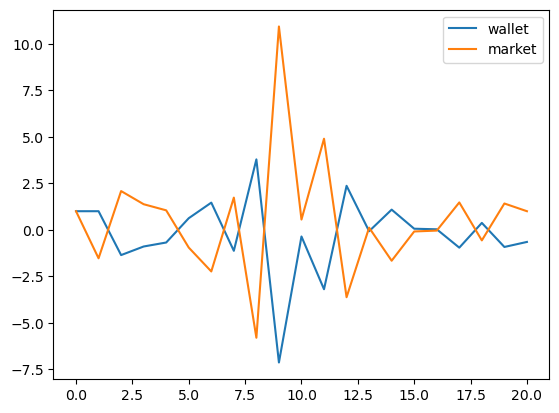

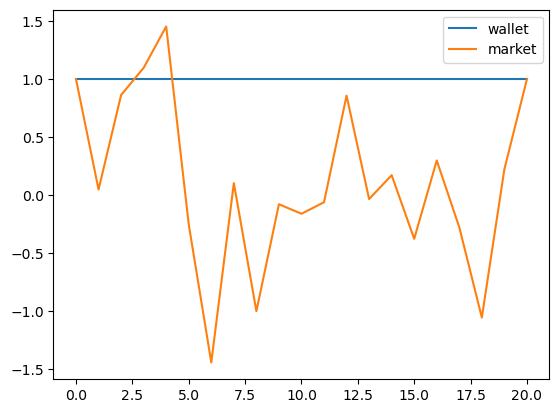

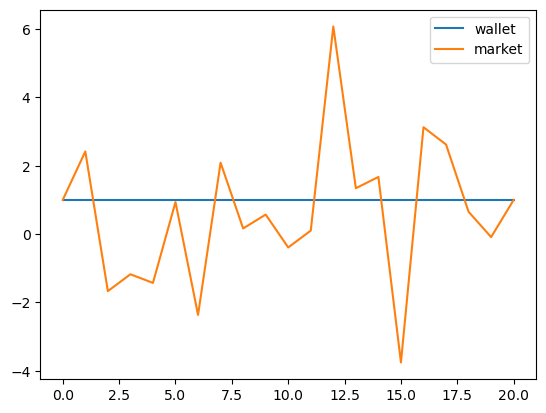

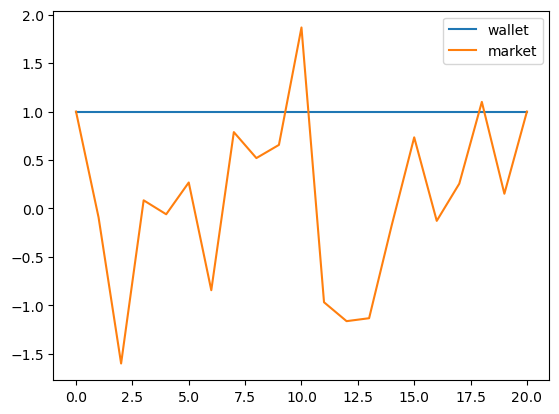

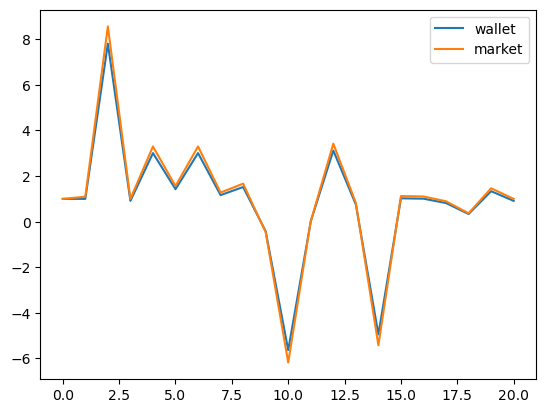

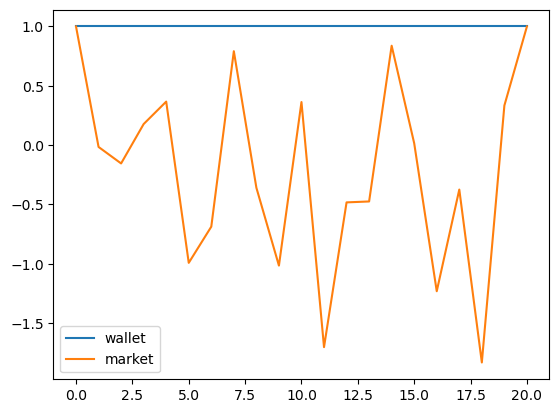

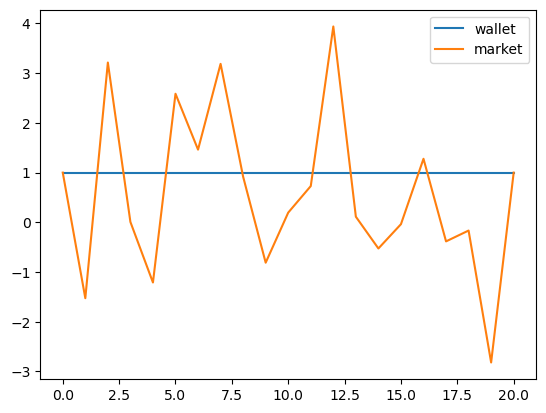

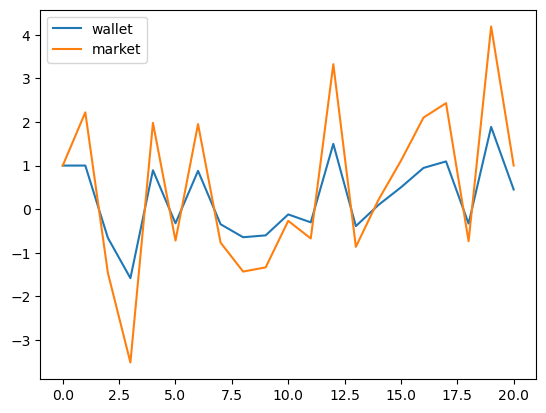

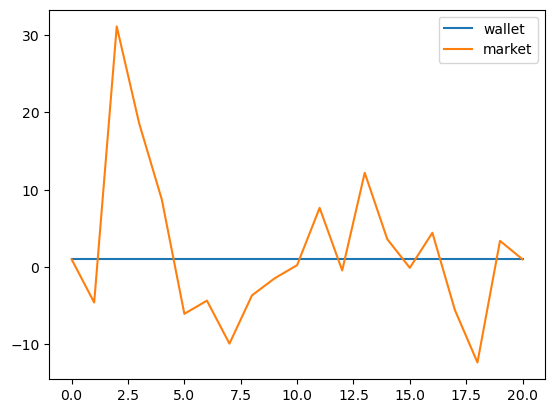

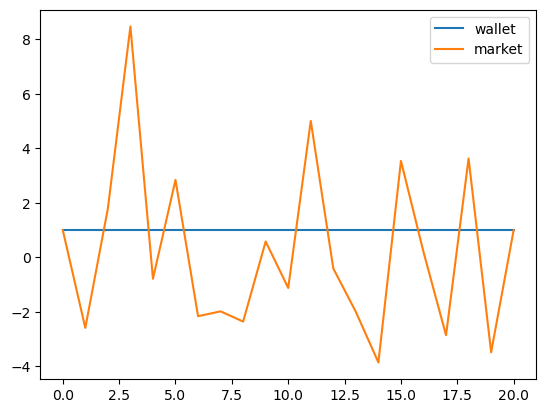

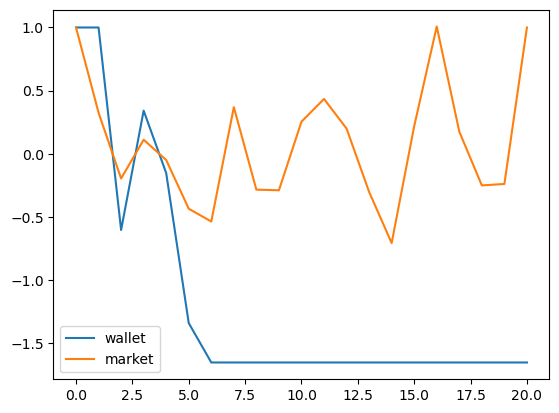

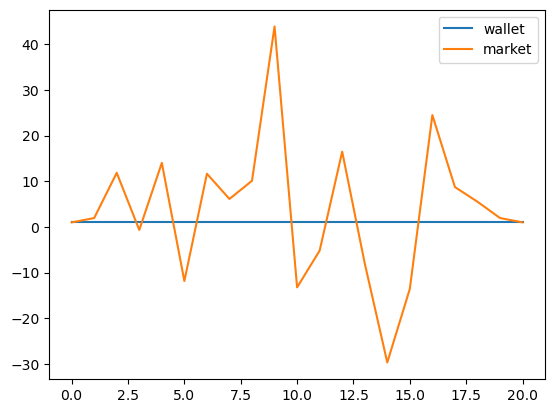

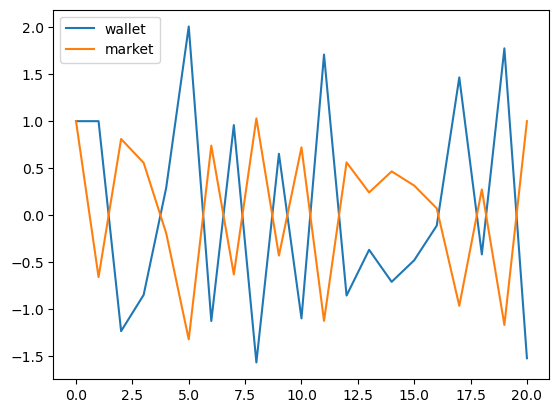

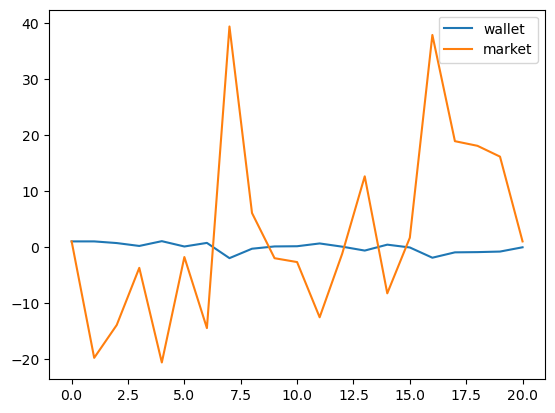

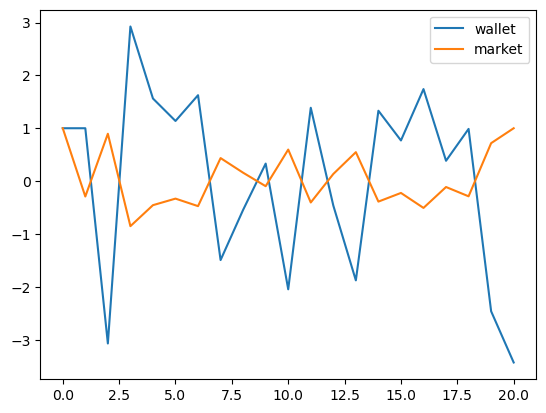

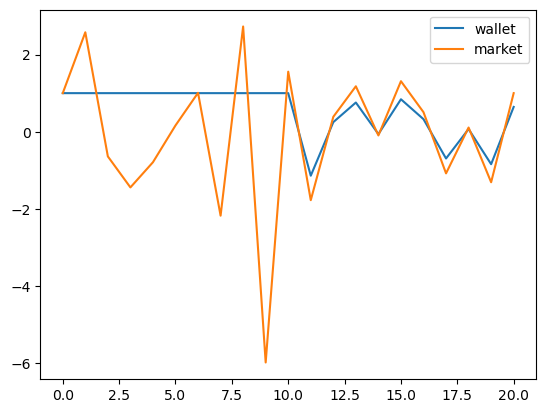

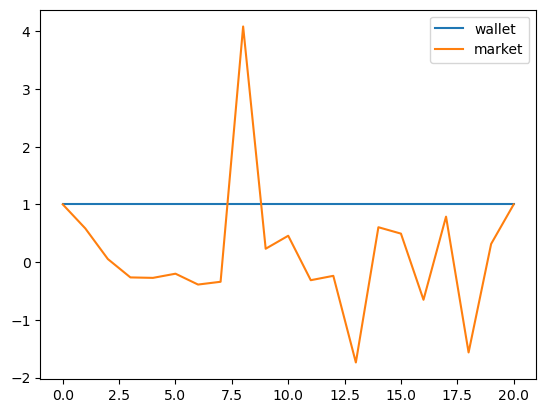

In [15]:
for i in range(len(json_object)):
    pd.DataFrame({"wallet":json_object[i]["wallet_history"],"market":json_object[i]["market_history"]}).plot()

In [16]:
edf = pd.read_csv("evaluation_results.csv")
edf.iloc[0].values

array([1, 'A', 0.0, 0.0, 0.0], dtype=object)

Hell yes — we’ve built a killer POC already, but now we enter the fun zone: **tightening screws, pushing limits, and future-proofing**.

Here are my **top strategic suggestions** to improve the system:

---

## 🔁 1. **Allow Agent to See the Context Directly**

Right now the agent **only trains on `target_df`** — even though the Transformer *could* learn from the `context_df`.

### 🔧 Option:

Concatenate `context_df + target_df` into one episode:

* Train the agent only on rewards from the `target_df` portion (e.g. via masking or zero rewards during context)
* Allows the Transformer to **build internal market memory naturally**

---

## 🧠 2. **Auxiliary Heads: Meta-Predictions**

Add small auxiliary outputs to the Transformer that:

* Predict future volatility
* Estimate next step reward
* Classify regime (trend, chop, revert)

Why?

> Forces the encoder to learn **richer representations** beyond just immediate actions.

---

## 📊 3. **Regime-Based Curriculum**

Instead of sampling all episodes equally:

* Stratify by volatility or trend
* Train easier episodes first
* Slowly introduce difficult / noisy environments

You can also **balance the regime mix** so the agent doesn't overfit to "easy" windows.

---

## 🔄 4. **Relative Advantage Evaluation**

Instead of just measuring reward:

* Compare to baseline strategies (random, hold)
* Define `agent_advantage = reward_agent - reward_baseline`

You already built the machinery — just run each `target_df` twice and subtract.

---

## 🧠 5. **RL Memory Injection (optional but powerful)**

If we move to **RecurrentPPO with LSTM memory**:

* Let the agent process `context_df` passively (no reward, no action)
* Then start the episode normally with memory *initialized*

This mimics how traders study history before acting.

---

## 🏗️ 6. **Online Deployment Skeleton**

Later, you could wire this up for:

* Daily retraining using recent data
* Live execution of agent policy on top tickers
* Continual journaling + self-analysis

Use a rolling horizon evaluation loop with `context → target` sliding forward by 1 week or 1 day.

---

## 📦 Bonus Tactical Tips

| Area              | Suggestion                                                      |
| ----------------- | --------------------------------------------------------------- |
| Logging           | Add `num_trades`, `avg_holding_time`, `win_rate` to journal     |
| Feature Expansion | Add cross-ticker info: sector trend, market index return        |
| Reward Design     | Add `position_penalty` to discourage churning                   |
| Model Variants    | Try `Transformer + LSTM`, or `Temporal Convolution + Attention` |

---

## ⚡ Want to act on any of these now?

I recommend either:

1. Concatenating `context + target` into single episodes (with smart reward masking)
2. Adding relative performance benchmarking (agent vs. random/hold)

Let me know and I’ll implement it right now.
